## Lab 1 - A-star

Implement the A* to the set cover problem

In [697]:
import numpy as np
from random import random
from functools import reduce
import queue
import matplotlib.pyplot as plt
from collections import namedtuple

In [698]:
PROBLEM_SIZE = 25
NUM_SETS = 64
State = namedtuple('state', ['taken', 'not_taken'])
SETS = tuple(np.array([random() < .5 for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))

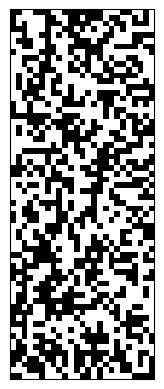

In [699]:
def draw_sol(indices):
    map = np.vstack([SETS[i] for i in indices])
    plt.imshow(map, cmap="binary")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show();

draw_sol(range(NUM_SETS))

In [700]:
def goal_check(state): # function to check if we found a set cover
    return len(state.taken) > 0 and np.all(reduce(np.logical_or, [SETS[i] for i in state.taken])) 

assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable" # check if the problem is solvable

In [701]:
def distance(state):
    return PROBLEM_SIZE - np.sum(reduce(np.logical_or, [SETS[i] for i in state.taken], [False for _ in range(PROBLEM_SIZE)]))

In [702]:
def find_solution(f = lambda s: len(s.taken), verbose=True): #f is the function that calculates the cost of reaching a state
    frontier = queue.PriorityQueue()
    frontier.put((PROBLEM_SIZE, State(set(), set(range(NUM_SETS)))))  #initial state
    _, curr_state = frontier.get()
    counter = 0
    while not goal_check(curr_state):
        counter += 1
        for action in curr_state.not_taken:
            new_state = State(curr_state.taken ^ {action}, curr_state.not_taken ^ {action}) #using XOR for both operations
            cost = f(new_state)
            frontier.put((cost, new_state))
        _, curr_state = frontier.get()
    if verbose:
        print("Found solution", curr_state.taken ,"in", counter, "steps.\nCost:", len(curr_state.taken))
        draw_sol(curr_state.taken)
    
    return len(curr_state.taken), counter

## Breadth First


Found solution {51, 43} in 1568 steps.
Cost: 2


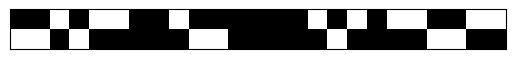

In [703]:
bf_cost, bf_steps = find_solution()

## Greedy Best First

Found solution {1, 59, 13} in 3 steps.
Cost: 3


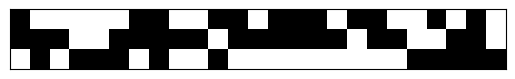

In [704]:
gbf_cost, gbf_steps = find_solution(distance)

# A*

The metric used to calculate the priority is

    f(n) = g(n) + h(n)

- g is the cost
- h is the heuristic (distance)

## First approach

- g = number of sets taken
- h = number of spots left to fill

Found solution {1, 59, 13} in 4 steps.
Cost: 3


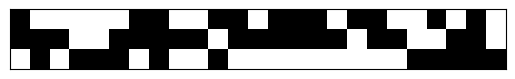

In [705]:
find_solution(lambda s: distance(s) + len(s.taken));

### Observations:
The first approach doesn't provide any improvement when compared to greedy best first.

## Adding a weight to g(n)
Let's try adding a weight to each edge traversed.

In [706]:
costs = []
steps = []
w = 0
curr_cost = None
while curr_cost is None or curr_cost > bf_cost:
    w += 1
    curr_cost, curr_steps = find_solution(lambda s: distance(s) + w * len(s.taken), verbose=False)
    print("w =", w, "steps:", curr_steps, "cost:", curr_cost)
    costs.append(curr_cost)
    steps.append(curr_steps)

MAX_WEIGHT = len(costs) + 1

w = 1 steps: 4 cost: 3
w = 2 steps: 7 cost: 3
w = 3 steps: 15 cost: 3
w = 4 steps: 31 cost: 3
w = 5 steps: 29 cost: 2


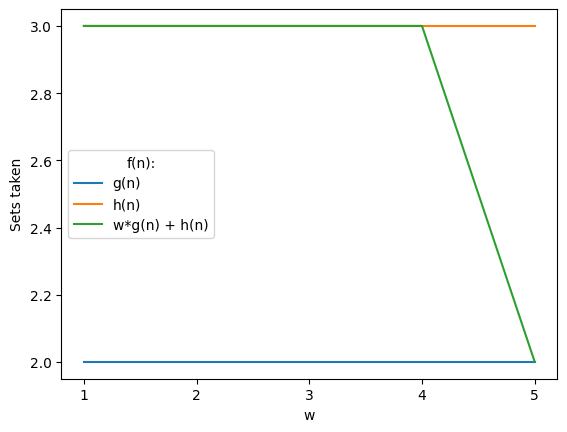

In [707]:
plt.plot(range(1, MAX_WEIGHT), [bf_cost for _ in range(1, MAX_WEIGHT)], label="g(n)")
plt.plot(range(1, MAX_WEIGHT), [gbf_cost for _ in range(1, MAX_WEIGHT)], label="h(n)")
plt.plot(range(1, MAX_WEIGHT), costs, label="w*g(n) + h(n)")
plt.xticks(np.arange(1, MAX_WEIGHT))
plt.xlabel("w")
plt.ylabel("Sets taken")
plt.legend(title="f(n):");

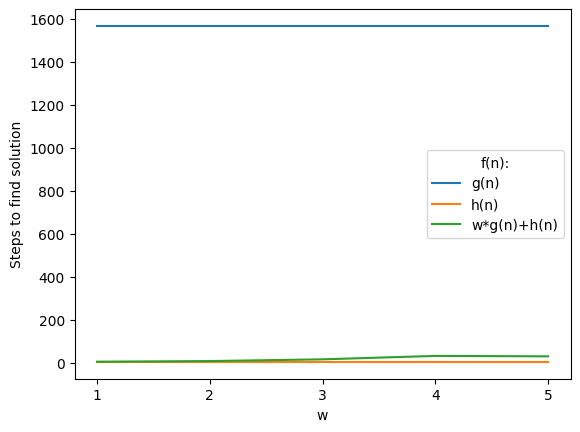

In [708]:
plt.plot(range(1, MAX_WEIGHT), [bf_steps for _ in range(1, MAX_WEIGHT)], label="g(n)")
plt.plot(range(1, MAX_WEIGHT), [gbf_steps for _ in range(1, MAX_WEIGHT)], label="h(n)")
plt.plot(range(1, MAX_WEIGHT), steps, label="w*g(n)+h(n)")
plt.xticks(np.arange(1, MAX_WEIGHT))
plt.xlabel("w")
plt.ylabel("Steps to find solution")
plt.legend(title="f(n):");

### Observations
Predictably, as w increases, the algorithm behaves more like uniform-cost search (becomes slower), however it reaches an optimal solution with relatively low values of w.